In [1]:
import jax
import jax.numpy as jnp
from jax import random, vmap
import numpyro 
from numpyro.infer import MCMC, NUTS, init_to_value
from matplotlib import pyplot as plt  
import numpyro.distributions as dist
from numpyro.distributions import constraints
import time
import numpy as np
import scipy.stats as stats
from jax.scipy.linalg import eigh
from jax.scipy.linalg import svd  
from mcmc_util import run_mcmc

from mcmc_util import *
plt.rcParams.update({
    "figure.figsize": (8, 5),        # Universal figure size
    "font.size": 20,                 # Universal font size
    "axes.titlesize": 20,            # Title font size
    "axes.labelsize": 20,            # Axis label font size
    "xtick.labelsize": 16,           # X-tick font size
    "ytick.labelsize": 16,           # Y-tick font size
    "legend.fontsize": 16,           # Legend font size
    "axes.grid": True,               # Enable grid by default
    "grid.alpha": 0.7,               # Grid transparency
    "axes.spines.top": False,        # Hide top spine
    "axes.spines.right": False,      # Hide right spine
})

[CpuDevice(id=0)]


In [2]:
randseed=0
key = random.PRNGKey(randseed)
key, subkey1, subkey2, subkey3 = random.split(key, 4)
plt.style.use('default') 

In [3]:
n, p, L = 100, 20,  5 #L is the number of pieces
Lambda0 = random.normal(subkey1, shape = (p, 2)) 

In [4]:

key = random.PRNGKey(0)
key, subkey1, subkey2, subkey3 = random.split(key, 4)
map_per_unit = 1
# Generate z1 and z2 using Beta distribution, then scale and shift
z1 = random.normal(subkey1, shape=(n, 1)) 
z2 = random.normal(subkey2, shape=(n, 1)) 
# Initialize y and assign first four columns
y =  jnp.hstack([z1,z2]) @ Lambda0.T + random.normal(subkey3, shape=(n, p)) * 0.1 
X = y
y = (X - X.mean(axis=0)) / np.sqrt(np.max(X))  

In [5]:
z1.shape

(100, 1)

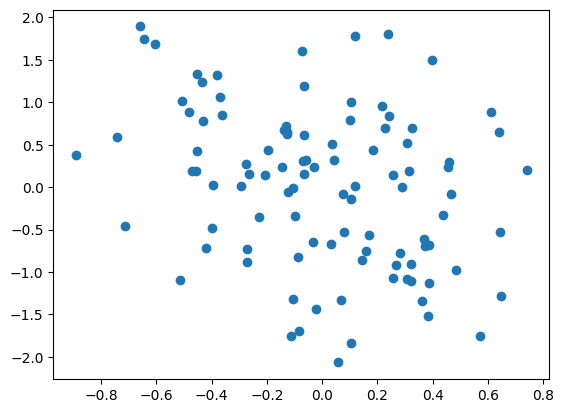

In [6]:
plt.scatter(y[:,0],y[:,2])

In [7]:
from mcmc_util import diffusion_dimension, diffusion_map

In [8]:
 
def diffusion_dimensio(y, eps, ratio, qmax = 10):
    n, p = y.shape  # n: number of data points, p: number of features
    
    # Step 1: Compute pairwise squared Euclidean distance using broadcasting
    diff = y[:, None, :] - y[None, :, :]  # Shape: (n, n, p)
    distances = jnp.linalg.norm(diff, axis=2)  # Shape: (n, n), squared Euclidean distances
    #eps = np.sort(distances.flatten())[int(n*n*.03)]
    print(eps)
    # Step 2: Apply Gaussian kernel and apply thresholding based on eps * C^2
    mask = distances < eps
    diff_masked = diff * mask[:, :, None]  # Apply mask to the difference matrix
    local_cov =  jnp.einsum('ijk,ijl->ikl', diff_masked, diff_masked) 
    eigvals = np.linalg.eigh(local_cov)[0]  # Shape (n, d), sorted in ascending order

    # Step 6: Extract the largest q eigenvalues and take the average over all k
    lam_mean = np.mean(eigvals[:, -qmax:], axis=0)
    q = len(lam_mean) 
    print(lam_mean)
    # Step 5: Find the dimension where the eigenvalue ratio falls below the threshold
    for i in range(q - 1):
        if lam_mean[q-i-2] / lam_mean[q-i-1] < ratio: 
            print('Anchor dimension by pretraining is '+ str(i+1))
            return (i+1)
        
            
    
    

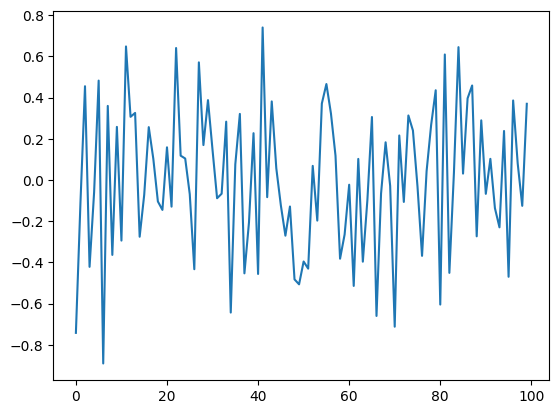

In [9]:
plt.plot(y[:,0])

0.9
[1.7221966e-04 9.5977401e-04 1.4599690e-03 2.9461898e-03 6.0885279e-03
 1.1921598e-02 2.1061573e-02 7.5566284e-02 4.8132771e-01 1.1111681e+00]
Anchor dimension by pretraining is 2


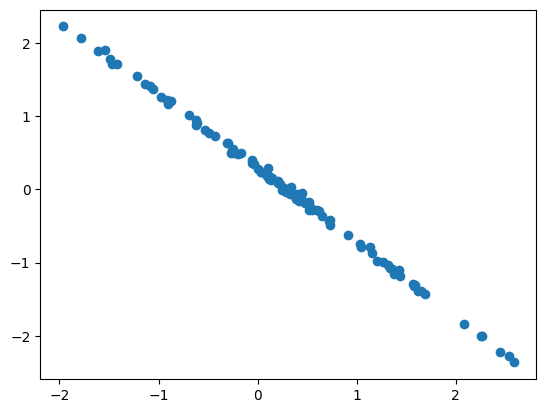

In [10]:
bandwidth = .9
ratio = .3
eps = 100.
diffusion_dimensio(y, eps = bandwidth, ratio =  ratio) 
ystar = diffusion_map(y, eps = eps, q= 2, C=100.)
ystar = (ystar - ystar.mean(axis=0)) / ystar.std(0)
K0 = ystar[:,0]
K1 = ystar[:,1 ]
#plt.scatter(K0, K1)
plt.scatter(z1, K0)

In [132]:
import importlib
import mcmc_util
importlib.reload(mcmc_util)
samples = mcmc_util.run_mcmc(y, L, map_per_unit = 4, burn =2000 , nmcmc= 2000, CoRe=False, sparsity=True, lam = 100., 
                   bandwidth = bandwidth, ratio_diff= ratio, eps_diff= eps, thinning=1, thresh=1.,
                             sig_Gamma = 1., sig2star = .01)

[CpuDevice(id=0)]


sample: 100%|█| 4000/4000 [04:09<00:00, 16.05it/s, 1023 steps of size 4.81e-03



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
    Gamma[0,0]     -0.02      1.04     -0.00     -1.75      1.76   3847.15      1.00
    Gamma[0,1]      0.00      1.12      0.01     -1.74      2.05   2900.42      1.00
    Gamma[0,2]     -1.55      0.14     -1.54     -1.76     -1.32    200.69      1.01
    Gamma[0,3]     -1.65      0.13     -1.64     -1.85     -1.43    142.44      1.00
    Gamma[0,4]      0.01      1.06     -0.00     -1.95      1.74   2976.16      1.00
    Gamma[0,5]     -0.00      1.07     -0.01     -1.97      1.65   3203.92      1.00
    Gamma[0,6]      0.03      1.07      0.03     -1.76      1.62   3113.26      1.00
    Gamma[0,7]      0.00      1.06     -0.02     -1.74      1.82   2681.72      1.00
    Gamma[1,0]      0.02      1.11      0.03     -1.74      1.95   2863.51      1.00
    Gamma[1,1]     -0.03      1.11     -0.01     -1.85      1.92   2252.58      1.00
    Gamma[1,2]      2.99      0.26      2.98      2.55      3.38

(array([ 4.,  2., 14., 13., 12., 19., 15., 10.,  7.,  4.]),
 array([0.12983151, 0.21647112, 0.30311072, 0.38975036, 0.47638994,
        0.56302959, 0.64966917, 0.73630875, 0.8229484 , 0.90958804,
        0.99622762]),
 <BarContainer object of 10 artists>)

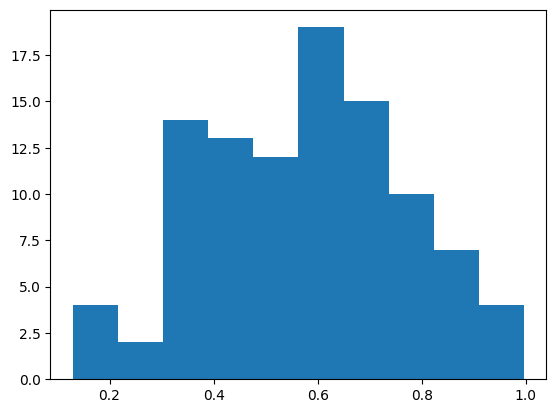

In [12]:
samples['u'].shape

plt.hist(samples['u'][-1][1])

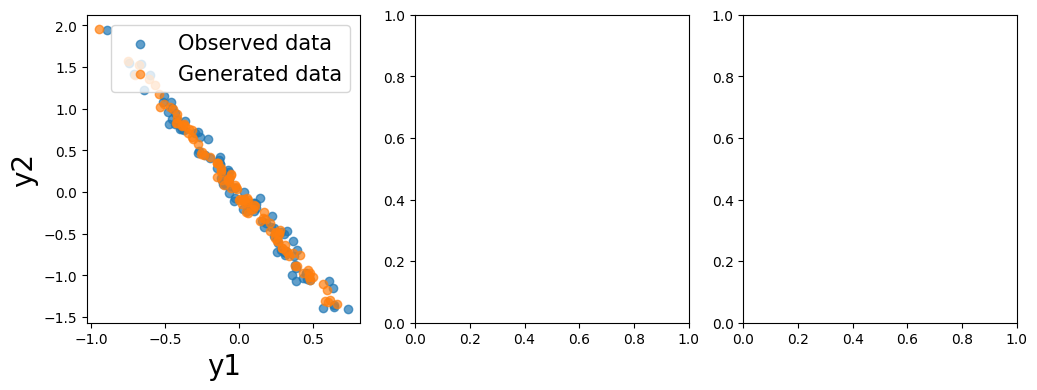

In [13]:
# Assume y and fitted_mean_y are already defined
#fitted_mean_y = jnp.mean(samples["fitted"][-1], axis=0)  # Average across samples
fitted_mean_y = samples["fitted"][-1]  # Example for one sample (if needed)

# Create a 1x2 grid for subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# First subplot: true y1 and y2 vs. fitted y1 and y2
axes[0].scatter(y[:, 0], y[:, 1], label='Observed data', alpha=0.7)
axes[0].scatter(fitted_mean_y[:, 0], fitted_mean_y[:, 1], label='Generated data', alpha=0.7)
#axes[0].set_title('Comparison of y1 and y2')
axes[0].set_xlabel('y1', fontsize=20)
axes[0].set_ylabel('y2', fontsize=20)
axes[0].legend( fontsize=15)





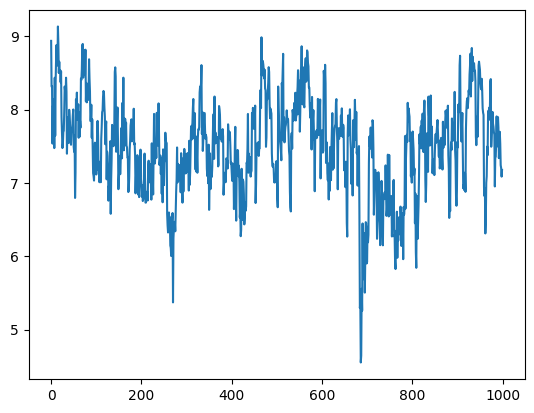

In [14]:
#plt.plot(samples['sigma2'])
plt.plot(samples['slopestar'][:,6,1]) 

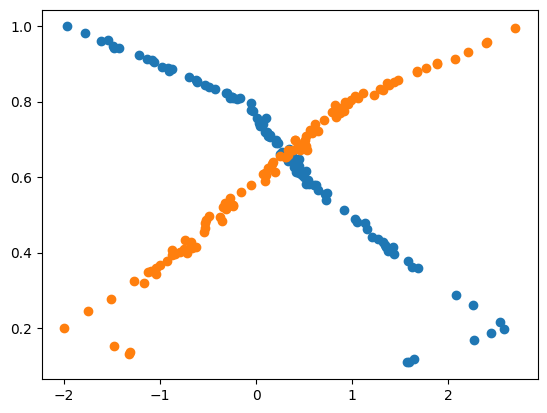

In [15]:
u = samples['u'][-1000]
plt.scatter(z1, u[0])
plt.scatter(z2, u[1])

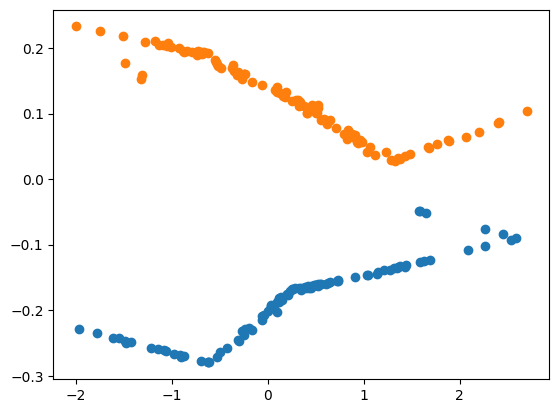

In [16]:
eta = samples['eta'][-1].T
plt.scatter(z1, eta[0])
plt.scatter(z2, eta[1])

In [17]:
### compare with Gaussia linear factor model and test trade-off on the penalty. 

In [18]:
import numpy as np
from scipy.linalg import svd
import numpy as np
def varimax(Phi, gamma = 1., q = 20, tol = 1e-6):
    from numpy import eye, asarray, dot, sum, diag
    from numpy.linalg import svd
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d - d_old < tol: break
    return dot(Phi, R), R
 
from factor_analyzer.rotator import Rotator  # Reliable Varimax implementation
from statsmodels.multivariate.factor import Factor
def varimax_alignment_submatrix(samples_Lambda, samples_eta, s):
    """
    Apply Varimax alignment to submatrices Lambda[:, :, ::s] using factor_analyzer.
    
    Parameters:
        samples_Lambda (np.ndarray): Array of shape (m, P, H).
        s (int): Step size to extract submatrices from the H dimension.
        
    Returns:
        np.ndarray: Array of aligned matrices of shape (m, P, H).
    """
    m, P, H = samples_Lambda.shape
    aligned_Lambda = np.copy(samples_Lambda)
    aligned_eta = np.copy(samples_eta)
    rotator = Rotator(method='varimax') 
    for i in range(m):
        for k in range(K): 
            submatrix_indices = np.arange(0, H, K) + k   #+ k Indices for submatrix
            submatrix = samples_Lambda[i, :, submatrix_indices]  # Extract submatrix (P, H_subset) 
            # Apply Varimax rotation using factor_analyzer
            rotated_submatrix, R = varimax(submatrix.T)  
            aligned_Lambda[i, :, submatrix_indices] = rotated_submatrix.T  # Replace aligned columns
            aligned_eta[i, :, submatrix_indices] =  R@samples_eta[i, :, submatrix_indices] 
        pivot = aligned_Lambda[0]
        for h in range(H): 
            dist_original = np.zeros(H)
            dist_flipped = np.zeros(H)
            for hh in range(H):
                dist_original[hh] = np.linalg.norm(aligned_Lambda[i, :, hh] - pivot[:, h])
                dist_flipped[hh] = np.linalg.norm(-aligned_Lambda[i, :, hh] - pivot[:, h]) 
            combined = np.concatenate([dist_original, dist_flipped]) 
            min_index = np.argmin(combined) 
            if min_index < len(dist_original):
                aligned_Lambda[i, :, h] = aligned_Lambda[i, :, min_index]
                np.delete(pivot, min_index, axis=1)  
            else:
                aligned_Lambda[i, :, h] = - aligned_Lambda[i, :, min_index - len(dist_original)]  
                np.delete(pivot, min_index- len(dist_original), axis=1)  
        
    return (aligned_Lambda, aligned_eta)
 

samples_Lambda = np.array(samples['Lambda'])
samples_eta = np.array(samples['eta'])
# Example usage
m, P, H = samples_Lambda.shape 
K = 2 # Example dimensions  
s = map_per_unit # Step size for selecting columns
aligned_Lambda, aligned_eta= varimax_alignment_submatrix(samples_Lambda, samples_eta, s)  

In [41]:

def rearrange_columns(A, K, L):
    """
    Rearranges the columns of matrix A (of shape (m, K*L))
    so that for each group of columns A[:, j + L*i] (i = 0, ..., K-1),
    the columns are sorted in descending order by their L2 norm.
    
    Parameters:
      A : numpy.ndarray of shape (m, K*L)
      K : number of columns in each group
      L : number of groups
      
    Returns:
      A_new : numpy.ndarray with rearranged columns.
    """
    m, total_cols = A.shape
    assert total_cols == K * L, "The number of columns must equal K*L."
    
    A_new = np.zeros_like(A)
    
    # Loop over each group index j (0-indexed, corresponds to columns 1, 1+L, etc. in 1-indexed notation)
    for j in range(L):
        # Indices for the group: j, j+L, j+2L, ..., j+(K-1)*L
        indices = [j + L * i for i in range(K)]
        group = A[:, indices]
        
        # Compute the L2 norm for each column in the group
        norms = np.linalg.norm(group, axis=0)
        
        # Get indices that would sort the norms in descending order
        sorted_order = np.argsort(-norms)
        
        # Rearrange the group based on the sorted order
        sorted_group = group[:, sorted_order]
        
        # Place the sorted columns back into their original group positions
        for i in range(K):
            A_new[:, j + L * i] = sorted_group[:, i]
        
        A_new[:,1] *= - 1
    return A_new  

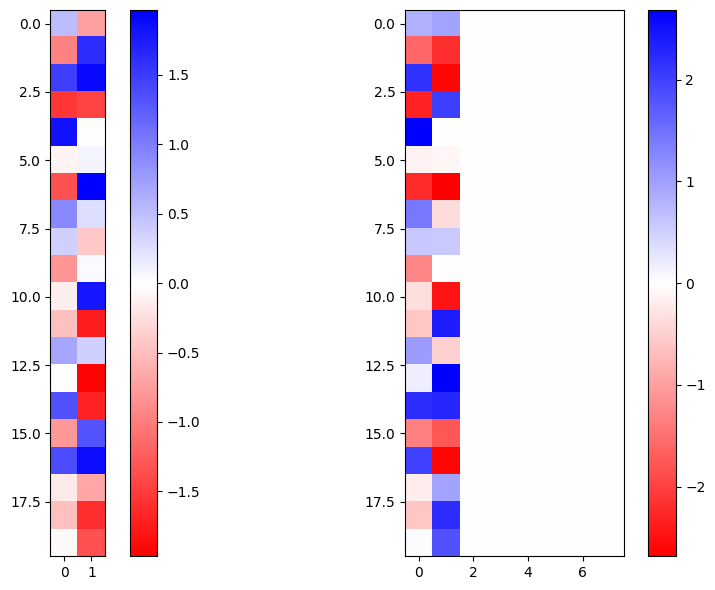

In [43]:
q1 = rearrange_columns(-np.quantile(samples_Lambda, .025, 0), 4, 2)

q2 = rearrange_columns(-np.quantile(samples_Lambda, .975, 0), 4, 2)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define a custom colormap
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["red", "white", "blue"])

# Set color normalization


# Create a figure with (1,2) subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # (1 row, 2 columns)

# Plot the first matrix (Lambda0)

colornorm = max(abs(Lambda0.min()),Lambda0.max())
norm = mcolors.Normalize(vmin=-colornorm, vmax=colornorm)
im0 = axes[0].imshow(Lambda0, cmap=cmap, norm=norm)
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04) 

# Plot the second matrix (-Lamb_mean)

Lamb_mean  = rearrange_columns(-samples_Lambda.mean(0), 4, 2)
Lamb_mean[:,1]*=-1
colornorm = max(abs(Lamb_mean.min()),-Lamb_mean.max())
norm = mcolors.Normalize(vmin=-colornorm, vmax=colornorm)
im1 = axes[1].imshow(Lamb_mean, cmap=cmap, norm=norm)
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04) 

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [51]:
### Uncertainty Quantificationabs
Lamb_arange_list = np.zeros(samples_Lambda.shape)
for i in range(1000):
    Lamb_arange_list[i,:,:] = rearrange_columns(-samples_Lambda[i], 4, 2)

q1 = np.quantile(Lamb_arange_list[500:1000], .025, 0)[:,0:2]

q2 = np.quantile(Lamb_arange_list[500:1000], .975, 0)[:,0:2]
np.mean((Lambda0 <q2 ) * (Lambda0>q1))

Array(0.15, dtype=float32)

In [60]:
Lamb_arange_list.shape

(1000, 20, 8)

In [61]:
 

def compute_LLt_coverage(Lambda_list, Lambda_true, level=0.95):
    m = len(Lambda_list)
    p, k = Lambda_true.shape

    # Compute true LL^T
    Q_true = Lambda_true @ Lambda_true.T

    # Compute posterior draws of LL^T
    Q_samples = np.array([L @ L.T for L in Lambda_list])  # shape: (m, p, p)

    # Compute lower and upper bounds for each (i, j)
    lower = np.percentile(Q_samples, (1 - level) / 2 * 100, axis=0)
    upper = np.percentile(Q_samples, (1 + level) / 2 * 100, axis=0)

    # Check coverage
    covered = (Q_true >= lower) & (Q_true <= upper)
    return np.mean(covered)  # overall coverage rate

    
compute_LLt_coverage(Lamb_arange_list[:,:,0:2], Lambda0, level=0.95)

Array(0.29, dtype=float32)

In [53]:
Lambda0

Array([[ 0.5162683 , -0.73668367],
       [-0.95720243,  1.614829  ],
       [ 1.4776376 ,  1.8863474 ],
       [-1.5504762 , -1.4388635 ],
       [ 1.8277926 , -0.02473702],
       [-0.0799012 ,  0.08346371],
       [-1.3361355 ,  1.9681005 ],
       [ 0.91923183,  0.2515907 ],
       [ 0.35642734, -0.42167938],
       [-0.8108211 ,  0.03319746],
       [-0.12700634,  1.7925719 ],
       [-0.47997668, -1.7391305 ],
       [ 0.6843411 ,  0.3565512 ],
       [ 0.00300883, -1.9416665 ],
       [ 1.3358544 , -1.6980498 ],
       [-0.79932594,  1.3134234 ],
       [ 1.3835006 ,  1.8692726 ],
       [-0.15748577, -0.68386096],
       [-0.48045355, -1.605121  ],
       [-0.04269479, -1.3236026 ]], dtype=float32)

In [54]:
((Lambda0 < q2 ) * (Lambda0>q1))

Array([[False, False],
       [False, False],
       [False, False],
       [False, False],
       [False,  True],
       [False,  True],
       [False, False],
       [False, False],
       [False, False],
       [False,  True],
       [False, False],
       [ True, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [ True, False],
       [ True, False],
       [False, False]], dtype=bool)

# 

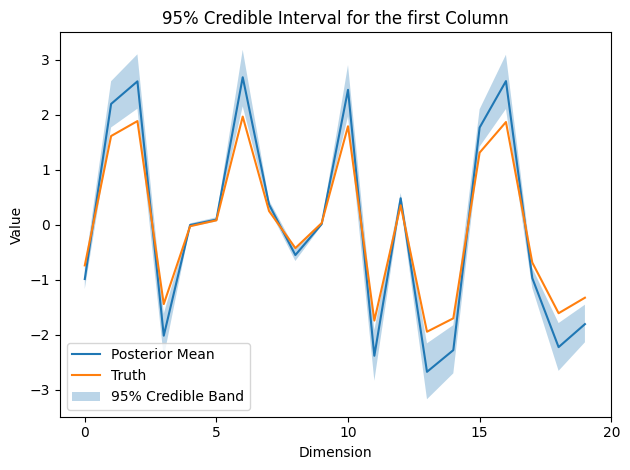

In [55]:
import numpy as np
import matplotlib.pyplot as plt
Lamb_mean  = rearrange_columns(-samples_Lambda.mean(0), 4, 2)
Lamb_mean[:,1]*=-1
colornorm = max(abs(Lamb_mean.min()),Lamb_mean.max())
# Example: 100 samples of a row vector of dim 20
M_samples = np.random.randn(100, 20)  # shape (S, d)

lower = q1[:,1]
upper = q2[:,1]
mean = -Lamb_mean[:,1]

x = np.arange(Lamb_mean.shape[0])
plt.plot(x, mean, label='Posterior Mean')
plt.plot(x, Lambda0[:,1], label='Truth')
plt.fill_between(x, lower, upper, alpha=0.3, label='95% Credible Band')
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.xticks([0, 5, 10, 15, 20])
plt.title('95% Credible Interval for the first Column')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define a custom colormap
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["red", "white", "blue"])

# Set color normalization



# Create a figure with (1,2) subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # (1 row, 2 columns)

# Plot the first matrix (Lambda0)

colornorm = max(abs(Lambda0.min()),Lambda0.max())
norm = mcolors.Normalize(vmin=-colornorm, vmax=colornorm)
im0 = axes[0].imshow(Lambda0, cmap=cmap, norm=norm)
plt.gca().invert_yaxis()
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04) 

# Plot the second matrix (-Lamb_mean)

colornorm = max(abs(Lamb_mean.min()),-Lamb_mean.max())
norm = mcolors.Normalize(vmin=-colornorm, vmax=colornorm)
im1 = axes[1].imshow(Lamb_mean, cmap=cmap, norm=norm)
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04) 
plt.yticks([0,5,10,15])
axes[1].set_title("Lamb_mean")
plt.gca().invert_yaxis()
# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [108]:
def gen_data(Lambda, slope, n, map_per_unit, K,  L, H):
    key = jax.random.PRNGKey(0)  # set random seed 
    u = jax.random.uniform(key, shape=(K, n)) 
    I_K = jnp.eye(K)  # K x K identity matrix
    W =  jnp.kron(jnp.ones((map_per_unit, 1)), I_K) 
    weighted_u = compute_upiece(u.T, W, L) 
    new_eta = compute_eta(slope, weighted_u, L, H, n)  
    return(new_eta @ Lambda.T)
  

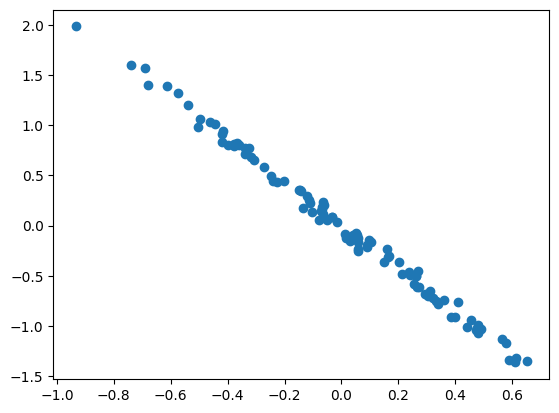

In [122]:
plt.scatter(y_array[500][:,0],y_list[500][:,1])

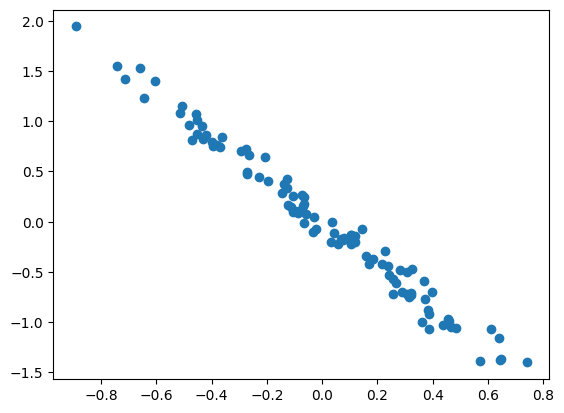

In [123]:
plt.scatter(y[:,0],y[:,1])

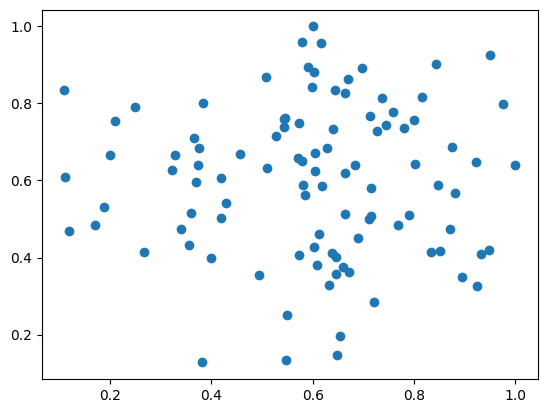

In [107]:
plt.scatter(samples['u'][100][0],samples['u'][100][1])

In [134]:
y_list = samples['generated'] 
def compute_joint_cdf_coverage_grid_support(true_Y, pred_list, K=5, level=0.95):
    """
    true_Y: (n, p) array
    pred_list: list of length m, each is (nstar, p) array
    """
    m = len(pred_list)
    nstar, p = pred_list[0].shape

    # define the support box
    mins = np.min(true_Y, axis=0)  # p-dim
    maxs = np.max(true_Y, axis=0)  # p-dim

    # create K points along each axis (not full grid)
    t_values = np.linspace(0.6, 1, K)
    target_points = np.array([mins + t * (maxs - mins) for t in t_values])  # shape (K, p)
    
    num_points = target_points.shape[0]

    # prepare results
    results = {
        'point_idx': [],
        'cdf_true': [],
        'cdf_lower': [],
        'cdf_upper': [],
        'covered': []
    }

    for i in range(num_points):
        y_target = target_points[i]

        # true CDF at y_target
        cdf_true = np.mean(np.all(true_Y <= y_target, axis=1))

        # posterior predictive CDFs
        cdf_post_list = np.zeros(m)
        for s in range(m):
            pred_matrix_s = pred_list[s]  # shape (nstar, p)
            pred_matrix_s += np.random.normal(scale=0.01, size=pred_matrix_s.shape)  # add small noise
            cdf_post_list[s] = np.mean(np.all(pred_matrix_s <= y_target, axis=1))

        # credible interval
        alpha = (1 - level) / 2
        lower = np.quantile(cdf_post_list, alpha)
        upper = np.quantile(cdf_post_list, 1 - alpha)

        results['point_idx'].append(i+1)
        results['cdf_true'].append(cdf_true)
        results['cdf_lower'].append(lower)
        results['cdf_upper'].append(upper)
        results['covered'].append(lower <= cdf_true <= upper)

    return pd.DataFrame(results)


 
y_array = np.stack(y_list, axis=0)   

df_results = compute_joint_cdf_coverage_grid_support(y, y_list, K=50, level=0.95)

print(df_results)

